## [Research](#Research_)
## [Imports](#Imports_)
## [Globals](#Globals_)
## [Utils](#Utils_)
## [Setup](#Setup_)
## [Часть 1. Нейросетевые рекомендации](#Часть_1._Нейросетевые_рекомендации_)

## Research <span id=Research_></span>
- [DSSM](https://posenhuang.github.io/papers/cikm2013_DSSM_fullversion.pdf)
- [BPE](https://paperswithcode.com/method/bpe)

## Imports <span id=Imports_></span>

In [178]:
%load_ext nb_black

import collections
import dataclasses
import einops
import functools
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import reprlib
import requests
import scipy
import seaborn as sns
import sklearn
import sklearn.preprocessing
import sys
import torch
import torch.nn.functional as F
import types
from typing import Callable, Literal, TypeVar
from tqdm.auto import tqdm
import urllib
import wandb
import youtokentome

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Globals <span id=Globals_></span>

In [5]:
CONFIG = types.SimpleNamespace()

DATA = types.SimpleNamespace()

MODEL = types.SimpleNamespace()

<IPython.core.display.Javascript object>

## Utils <span id=Utils_></span>

In [149]:
def make_new_markdown_section_with_link(section, header_size: int = 2, do_print=True):
    header = "#" * header_size
    section_id = section.replace(" ", "_") + "_"
    section_link = f"{header} [{section}](#{section_id})"
    section_header = f"{header} {section} <span id={section_id}></span>"
    if do_print:
        print(section_link + "\n" + section_header)
    return section_link, section_header


def get_yadisk_download_url(
    yadisk_url: str,
    base_url="https://cloud-api.yandex.net/v1/disk/public/resources/download?",
) -> str:
    final_url = base_url + urllib.parse.urlencode(dict(public_key=yadisk_url))
    response = requests.get(final_url)
    download_url = response.json()["href"]
    return download_url


def write_url_response_content_to_file(url: str, filename: str) -> None:
    download_response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(download_response.content)


def write_yadisk_url_content_to_file(yadisk_url) -> str:
    url = get_yadisk_download_url(yadisk_url=yadisk_url)
    filename = urllib.parse.parse_qs(url)["filename"][0]
    write_url_response_content_to_file(
        url=url,
        filename=filename,
    )
    return filename


def unzip(zip_path: str, save_path=None, delete_zip=False):
    !unzip {zip_path} {"-d " + save_path if save_path else ""}

    if delete_zip:
        for path in glob.glob(zip_path):
            if path.endswith(".zip"):
                !trash {path}


def tar(tar_archive: str, save_directory=None, delete_archive=False):
    !tar -xvf {tar_archive} {"--directory " + save_directory if save_directory else ""}

    if delete_archive:
        !trash {tar_archive}


def path_to_dict(path, print_only_last_dirname=False):
    dirpath, dirnames, filenames = next(os.walk(path))
    path_contents = filenames

    for dirname in dirnames:
        full_dirname = os.path.join(path, dirname)
        path_contents.append(path_to_dict(full_dirname, print_only_last_dirname=True))

    if print_only_last_dirname:
        path = os.path.split(path)[-1]

    return {path: path_contents}


def pprint_path_contents(path):
    path_dict = path_to_dict(path)
    short_path_repr = reprlib.repr(path_dict)
    short_path_dict = eval(short_path_repr)
    string = pprint.pformat(short_path_dict).replace("Ellipsis", "...")
    print(string)

<IPython.core.display.Javascript object>

## Setup <span id=Setup_></span>

In [186]:
sns.set()
CONFIG.device = "cuda" if torch.cuda.is_available() else "cpu"
CONFIG.debug = True

<IPython.core.display.Javascript object>

In [87]:
DATA.yadisk_url = "https://disk.yandex.ru/d/-OigCs1K-ZaUJw"
DATA.folder = "data/lab_recommending_zen"

<IPython.core.display.Javascript object>

In [96]:
!mkdir {DATA.folder}

<IPython.core.display.Javascript object>

In [ ]:
tar(
    tar_archive=write_yadisk_url_content_to_file(DATA.yadisk_url),
    save_directory=DATA.folder,
    delete_archive=True,
)

In [142]:
for dirpath, dirnames, filenames in os.walk(DATA.folder):
    for filename in filenames:
        if filename.endswith("gz"):
            path = os.path.join(dirpath, filename)
            !gunzip {path}

<IPython.core.display.Javascript object>

In [155]:
pprint_path_contents(DATA.folder)

{'data/lab_recommending_zen': [{'zen_dataset': ['item_counts.csv',
                                                'user_ratings',
                                                'item_meta']}]}


<IPython.core.display.Javascript object>

## Часть 1. Нейросетевые рекомендации <span id=Часть_1._Нейросетевые_рекомендации_></span>

В этом задании вам предстоит обучить свою рекомендательную нейросетевую модель для рекомендаций текстовых статей на основе датасета Дзена.

Как обсуждалось на лекции, нередко в нейросетевых рекомендациях используют архитектуры типа DSSM. Предлагается построить и обучить модель именно такого вида.

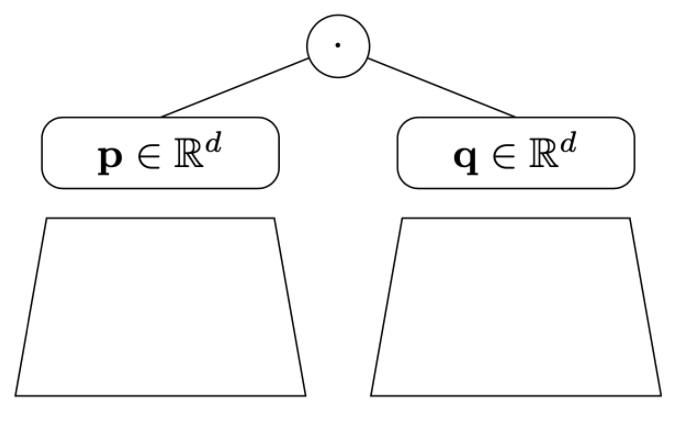


Модель состоит из двух нейросетевых частей:
1. Айтемная. Принимает на вход мешок слов, из которых состоит текст.
2. Пользовательская. Принимает на вход мешок слов из текстов айтемов, которые понравились пользователю.

Обучать такую модель можно на FPS-лосс.

*Замечания:*
1. Приведенная в ноутбуке схема приблизительная, можно предложить свою с пояснениями улучшений.
2. При обучении из пользовательской истории нужно выкидывать айтем, который подаем в айтемную.

In [162]:
# from torch.utils.data import DataLoader, Dataset
# from sklearn.metrics import roc_auc_score

<IPython.core.display.Javascript object>

## Обработка датасета

In [165]:
DATA.item_counts = pd.read_csv(
    os.path.join(DATA.folder, "zen_dataset/item_counts.csv"), index_col=0
)
DATA.item_meta = pd.read_csv(
    os.path.join(DATA.folder, "zen_dataset/item_meta"), index_col=0
)
DATA.user_ratings = pd.read_csv(
    os.path.join(DATA.folder, "zen_dataset/user_ratings"), index_col=0
)

<IPython.core.display.Javascript object>

In [190]:
if CONFIG.debug:
    DATA.item_counts = DATA.item_counts.sample(10_000)

<IPython.core.display.Javascript object>

In [191]:
DATA.item_counts["itemId"] = DATA.item_counts["itemId"].apply(str)
DATA.item_meta["itemId"] = DATA.item_meta["itemId"].apply(str)

<IPython.core.display.Javascript object>

В `user_ratings` записаны трейновые и тестовые рейтинги пользователей в виде строк, следующая функция парсит это представление в словарь, ключи &mdash; id айтемов, значения &mdash; рейтинги.

In [192]:
def parse_ratings_history(string):
    return json.loads(string.replace("'", '"'))

<IPython.core.display.Javascript object>

In [202]:
DATA.user_encoder = sklearn.preprocessing.LabelEncoder().fit(
    DATA.user_ratings["userId"]
)
DATA.item_encoder = sklearn.preprocessing.LabelEncoder().fit(DATA.item_counts["itemId"])

all_items = DATA.item_counts["itemId"]
indices = DATA.item_encoder.transform(all_items)
DATA.item_id_to_index = dict(zip(all_items, indices))

<IPython.core.display.Javascript object>

##  Токенизация

Поскольку всего в датасете очень много разных слов, проблематично применять мешок слов для такого большого словаря, поэтому хотелось бы его уменьшить. Часто используемым (и предложенном в оригинальной статье) методом является разбиение текстов на буквенные триграммы, но мы применим токенизацию byte pair encoding (BPE).

Верхнеуровнево она устроена следующим образом:
* Изначально добавляем в словарь все индивидуальные символы;
* Из всех пар уже добавленных в словарь токенов выберем самую встречающуюся в текстах, объединим их и добавим в словарь.
* Повторяем предыдущий пункт, пока не наберем словарь нужной длины.

Таким образом, словарь будет содержать в виде отдельных токенов популярные части слов и даже целые слова, а менее популярные будут складываться из нескольких токенов. Подробнее: [1](https://en.wikipedia.org/wiki/Byte_pair_encoding), [2](https://towardsdatascience.com/byte-pair-encoding-the-dark-horse-of-modern-nlp-eb36c7df4f10).

Для токенизации можно воспользоваться библиотекой [YouTokenToMe](https://github.com/VKCOM/YouTokenToMe).

* Обучим BPE на текстах из датасета, один айтем можно представить в виде `title + \t + content`.
* Затем преобразуем все тексты в последовательность токенов. Чтобы уменьшить размер датасета, можно оставлять только первые 100 токенов.
* Стоит привести тексты к нижнему регистру и избавиться от знаков препинания.

In [ ]:
CONFIG.dict_size = 50000

In [205]:
DATA.item_meta.iloc[0]

itemId                                   5480844460835530524
title      Нехитрые способы, как самостоятельно проверить...
content      С раннего детства нам рассказывают, что сама...
Name: 0, dtype: object

<IPython.core.display.Javascript object>

In [ ]:
# YOUR CODE HERE

## Модель

### Датасет

Сконструируем датасет для обучения модели. Один элемент датасета &mdash; пара пользователь-айтем, между которыми было **положительное** взаимодействие.

Кроме того, можно мешок слов представлять в сжатом виде, как словарь частоты встречаемости токенов (`token -> count`).

In [ ]:
class BagOfWordsDataset(Dataset):
    def __init__(self, user_ratings, ratings_column, tokens, user_encoder, item_encoder, ...):
        self.per_item_tokens = ...        # Для каждого айтема мешок слов в сжатом виде
        self.per_user_tokens = ...        # Для каждого пользователя мешок слов в сжатом виде всех айтемов из положительных взаимодействий
        self.positive_interactions = ...  # Позитивные взаимодействия из датасета
    
    def __len__(self):
        return len(self.positive_interactions)
    
    def __getitem__(self, i):
        user_id, item_id = self.positive_interactions[i]
        
        # YOUR CODE HERE
        
        return user_tokens, item_tokens

In [ ]:
train_dataset = BagOfWordsDataset(user_ratings, 'trainRatings', tokens, user_encoder, item_to_id)

Датасет возвращает данные в сложном формате, именно для таких случаев в [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) в torch есть функциональность [collate_fn](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data).

In [ ]:
def collate_fn(batch):
    """
    Принимает на вход список объектов, которые вернул датасет, и приводит их к набору тензоров
    в правильном формате
    """
    user_tokens, item_tokens = zip(*batch)
    
    # YOUR CODE HERE
    
    return ...

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=8, pin_memory=True)

Для удобной работы с пользователями и айтемами по-отдельности заведем для них отдельные датасеты. Это поможет, например, прогнать юзеров и айтемов через юзерскую и айтемную часть dssm и получить их эмбеддинги.

In [ ]:
class OnePartDataset(Dataset):
    def __init__(self, per_item_tokens):
        self.per_item_tokens = per_item_tokens
    
    def __len__(self):
        return len(self.per_item_tokens)
    
    def __getitem__(self, i):
        return i, self.per_item_tokens[i]


def create_user_item_datasets(train_dataset):
    user_dataset = ...
    item_dataset = ...
    
    return user_dataset, item_dataset

In [ ]:
user_dataset, item_dataset = create_user_item_datasets(train_dataset)

In [ ]:
def collate_fn_part(batch):
    """
    Принимает на вход список объектов, которые вернул OnePartDataset, и приводит их к набору тензоров
    в правильном формате
    """
    ...

In [ ]:
user_loader = DataLoader(user_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn_part, num_workers=0)
item_loader = DataLoader(item_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn_part, num_workers=0)

### Модель

Комментарии:
* Стоит обратить внимание на слой [nn.EmbeddingBag](https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html). Представления текстов в сжатом виде можно к нему адаптировать.
* Из-за того, что токенов в одном айтеме и тем более пользователе может быть очень много, суммирование эмбеддингов токенов может привести к численной нестабильности. Можно суммировать эмбеддинги токенов с весом $1 \big/ \sqrt{\text{количество токенов}}$.


Будем учить модель на FPS loss.

In [ ]:
def fps_loss(item_embs, user_embs):
    loss = ...

    return loss

In [ ]:
def test_fps_loss():
    user_embs = torch.tensor([[1.0, 2.0, 3.0], [3.0, 2.0, 1.0], [7.0, 8.0, 9.0]])
    item_embs = torch.tensor([[5.0, 3.0, 6.0], [2.0, -2.0, 0.0], [-15.0, 1.0, 2.0]])
    ratings = torch.ones(3)
    assert np.isclose(fps_loss(user_embs, item_embs, ratings).item(), 52.0120)

    N = 100
    losses = []
    for _ in range(10 ** 4):
        user_embs = torch.rand(N, 1)
        item_embs = torch.rand(N, 1)
        ratings = torch.ones(N)
        losses.append(fps_loss(item_embs[torch.randperm(N)], user_embs, ratings).item())
    assert np.isclose(np.mean(losses), 4.62, atol=1e-2)
          
test_fps_loss()

In [ ]:
EMBEDDING_SIZE = 10

In [ ]:
class BagOfWordsDSSM(nn.Module):
    def __init__(self, dict_size=DICT_SIZE, embedding_size=EMBEDDING_SIZE):
        super(BagOfWordsDSSM, self).__init__()
        # YOUR CODE HERE

    def get_user_embeddings(self, users_info):
        """Пользовательская часть DSSM"""
        user_embeddings = ...
        return user_embeddings

    def get_item_embeddings(self, items_info):
        """Айтемная часть DSSM"""
        item_embeddings = ...
        return item_embeddings
    
    def forward(self, users_info, items_info):
        # YOUR CODE HERE

In [ ]:
model = BagOfWordsDSSM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Для оценки качества будем считать усредненный по пользователям ROC-AUC на тестовых данных.

In [ ]:
def calculate_per_user_auc(user_embeddings, item_embeddings, user_ratings, column):
    """
    * user_embeddings - np.array из эмбеддингов пользователей
    * item_embeddings - np.array из эмбеддингов айтемов
    * user_ratings - pd.DataFrame датасета
    * column - название колонки таблицы с рейтингами
    """
    aucs = []
    user_ids = user_encoder.transform(user_ratings['userId'])
    for user_id, item_ratings in tqdm.notebook.tqdm(zip(user_ids, user_ratings[column]), total=len(user_ids)):
        item_ids, item_ratings = zip(*parse_ratings_history(item_ratings).items())
        if len(set(item_ratings)) == 1:
            continue
        item_ids = [item_to_id[item_id] for item_id in item_ids]

        user_embedding = user_embeddings[user_id]
        item_embedding = item_embeddings[item_ids]

        scores = (user_embedding * item_embedding).sum(axis=-1)

        roc_auc = roc_auc_score(item_ratings, scores)
        aucs.append(roc_auc)
    return np.mean(aucs)

In [ ]:
# Пример использования функции

# calculate_per_user_auc(np.random.randn(len(user_encoder.classes_), EMBEDDING_SIZE),
#                        np.random.randn(len(item_encoder.classes_), EMBEDDING_SIZE),
#                        user_ratings, 'testRatings')

In [ ]:
from IPython.display import clear_output

def train(model, optimizer, train_loader, n_epochs=5):
    loss_history = []
    per_user_auc = []
    for epoch in range(n_epochs):
        for batch in tqdm.tqdm(train_loader, desc=f'Epoch {epoch}'):
            model.train()
            
            user_embs, item_embs = ...
            loss = ...
            # OPTIMIZER STUFF
            
            loss_history.append(loss.item())

            if len(loss_history) % 10000 == 0:
                user_embeddings = ...
                item_embeddings = ...
                auc = ...
                per_user_auc.append(auc)
            
            if len(loss_history) % 1000 == 0:
                clear_output(wait=True)
                plt.figure(figsize=(14, 6))
                plt.plot(loss_history)
                plt.title('Train loss')
                plt.yscale('log')
                plt.subplot(1, 2, 2)
                plt.plot(np.arange(1, len(per_user_auc) + 1) * 10000, per_user_auc)
                plt.title('Per user AUC')
                plt.savefig(f'images/{EMBEDDING_SIZE}.jpg')
                plt.show()

In [ ]:
train(model, optimizer, train_loader)

In [ ]:
user_embeddings = ...
item_embeddings = ...
auc = ...

In [ ]:
print('Test ROC-AUC:', auc)

Тут можно написать интересные замечания и выводы по модели и ее обучению.

**Выводы:**

# Часть 2. Ранжирующая модель



Классический пайплайн рекомендаций выглядит следующим образом:

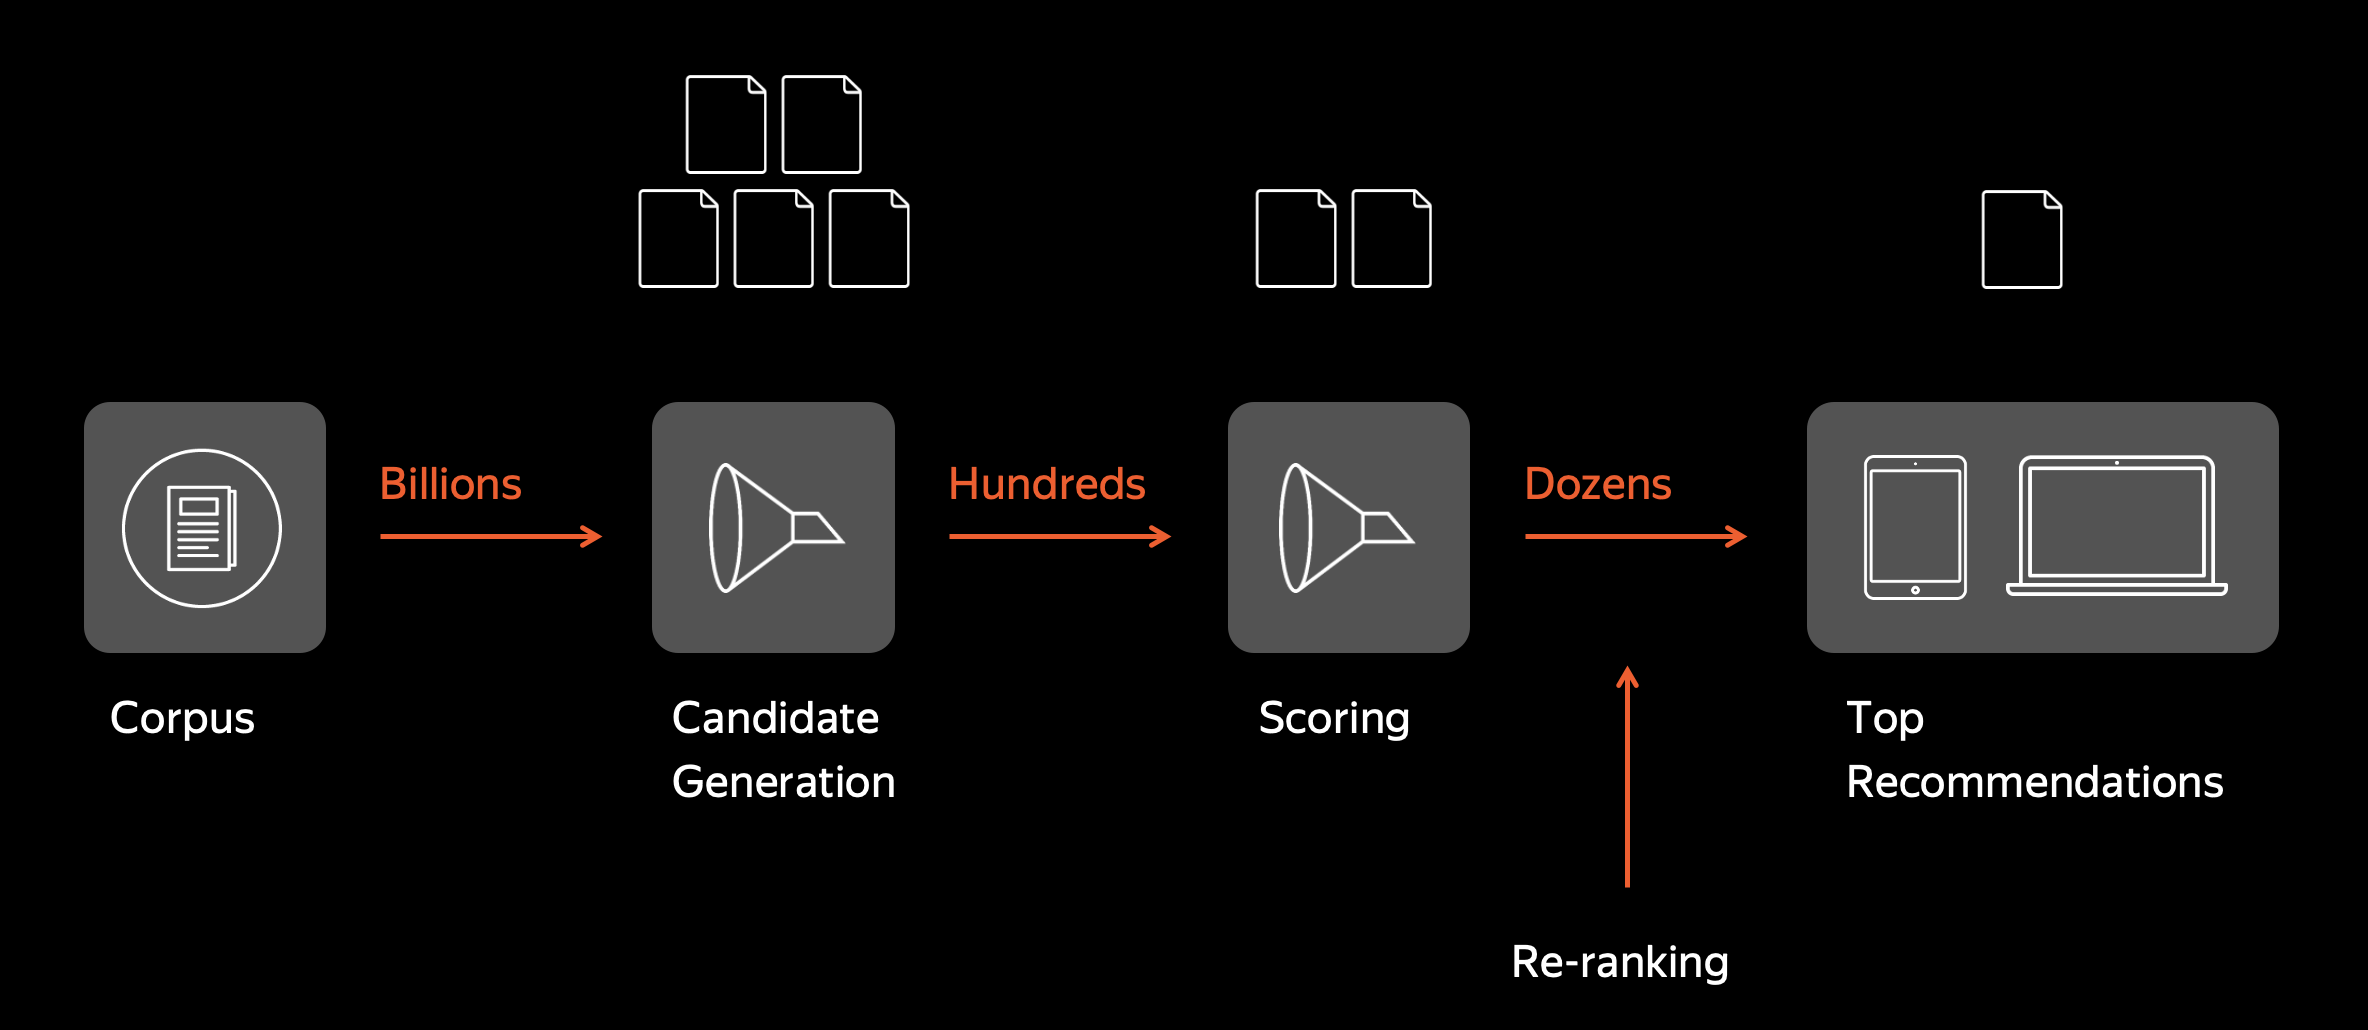

* Отбор кандидатов. Сначала из всей базы документов отбирается некоторое количество кандидатов. Это нужно, потому что в реальном сервисе очень большое количество документов и невозможно на каждый запрос отскорить всё. В качестве "селекторов" могут выступать простые с вычислительной точки зрения модели (например, kNN по эмбеддингам, предсказание FM, SLIM).
* Ранжирующая модель. Отобранные на предыдущем шаге айтемы ранжируются моделью, чтобы отобрать топ документов для пользователя.
* Затем айтемы дополнительно переранжируются с учетом бизнес-логики.

Более подробно этот пайплайн обсуждался на лекции 1.

В этом задании вам предстоит построить и обучить ранжирующую модель на датасете Дзена.

В качестве самой модели применяют модели на основе градиентного бустинга, в данном задании предлагается использовать CatBoost. В качестве фичей модели используем
* Скалярное произведение, косинусное расстояние между пользовательским и айтемным эмбеддингами. Эмбеддинги: *explicit ALS*, *implicit ALS*, *DSSM*.
* Айтемные и пользовательские статистики (ctr, количество показов и т.п.)

## ALS

Обучите explicit и implicit ALS.  
Можете использовать, как свою реализацию из первого задания, так и реализации из публичных библиотек (Implicit, Lightfm, Surprise, LensKit, etc.) 

In [ ]:
DIMENSION = 10

In [ ]:
eals_user_embeddings, eals_item_embeddings = ...

In [ ]:
ials_user_embeddings, ials_item_embeddings = ...

In [ ]:
dssm_user_embeddings, dssm_item_embeddings = ...

## Catboost

Построим эмбеддинговые признаки пары пользователь-айтем.

In [ ]:
class EmbeddingFeatureGetter:
    def __init__(self, user_embeddings, item_embeddings):
        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings
    
    def get_features(self, user_id, item_ids):
        """
        * user_id -- индекс пользователя для построения признаков
        * item_ids -- список индексов айтемов
        """
        ...

        return dot, cos

In [ ]:
eals_features_getter = EmbeddingFeatureGetter(eals_user_embeddings, eals_item_embeddings)
ials_features_getter = EmbeddingFeatureGetter(ials_user_embeddings, ials_item_embeddings)
dssm_features_getter = EmbeddingFeatureGetter(dssm_user_embeddings, dssm_item_embeddings)

Построим айтемные и пользовательские признаки.

In [ ]:
item_features = [...]

In [ ]:
user_features = [...]

Для построения модели catboost будем пользоваться одноименной [библиотекой](https://catboost.ai/en/docs/concepts/python-reference_catboost). Для обучения модели удобно использовать интерфейс библиотеки, с использованием представления данных `Pool`.

In [ ]:
!pip install catboost

In [ ]:
import catboost

In [ ]:
train_features = ...
train_labels = [...]
train_group_ids = [...]

In [ ]:
train_pool = catboost.Pool(train_features, train_labels, group_id=train_group_ids)

In [ ]:
test_features = ...
test_labels = [...]
test_group_ids = [...]

In [ ]:
test_pool = catboost.Pool(test_features, test_labels, group_id=test_group_ids)

Обучим саму модель. В [документации](https://catboost.ai/en/docs/references/training-parameters/common#loss_function) есть описание того, как передавать лосс, и какие функции возможны.

Попробуйте обучить на лосс бинарной классификации и ранжирования (второе стоит учить с маленьким числом генерируемых пар на `group_id` во избежание вычислительных трудностей).

In [ ]:
cb = catboost.CatBoost({...})

In [ ]:
cb.fit(train_pool, eval_set=test_pool)

In [ ]:
Оценим качество

In [ ]:
per_user_predictions = [...]  # user -> predictions

In [ ]:
def calculate_per_user_auc(user_ratings, per_user_predictions):
    pass

In [ ]:
per_user_auc = calculate_per_user_auc(user_ratings, per_user_predictions)
print(np.mean(per_user_auc))

**Выводы:**